In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openai
#openai.api_key = os.environ['OPENAI_API_KEY']

openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data
import logging
import pickle



In [2]:
def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    #'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    #'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    #'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {

    #'LLMTime GPT-3': get_llmtime_predictions_data,
    #'LLMTime GPT-3.5': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    #'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())



In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [4]:
x = np.linspace(0,10,100)
train = np.sin(x[0:50])
test = np.sin(x[50:100])

In [5]:
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)

NameError: name 'ds_name' is not defined

In [6]:
model_hypers['LLMTime GPT-4']

{'model': 'gpt-4',
 'alpha': 0.3,
 'basic': True,
 'temp': 1.0,
 'top_p': 0.8,
 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}

In [7]:
hypers = list(grid_iter(model_hypers['LLMTime GPT-4']))
hypers

[defaultdict(dict,
             {'model': 'gpt-4',
              'alpha': 0.3,
              'basic': True,
              'temp': 1.0,
              'top_p': 0.8,
              'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')})]

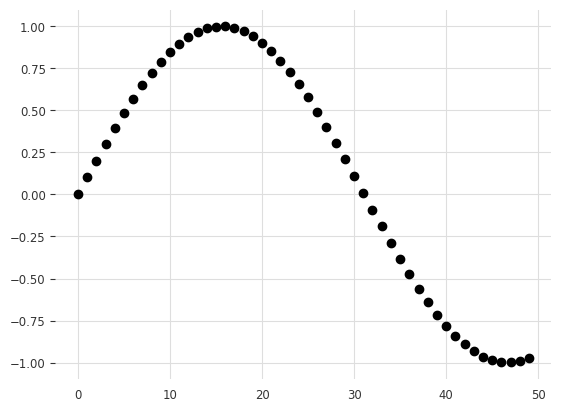

In [8]:
import matplotlib.pyplot as plt
plt.plot(train,'o')
plt.show()

In [9]:
pred_dict = get_autotuned_predictions_data(train, test, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


  0%|                                                     | 0/1 [00:00<?, ?it/s]

AuthenticationError: Incorrect API key provided: sk-Li651***************************************MtBp. You can find your API key at https://platform.openai.com/account/api-keys.

In [134]:
pred_dict

{'samples':          50        51        52        53        54        55        56  \
 0 -0.943285 -0.905275 -0.857641 -0.801347 -0.737355 -0.665664 -0.586757   
 1  0.943285  0.905275  0.858122  0.801828  0.737836  0.666146  0.587719   
 2 -0.942804 -0.904794 -0.857160 -0.800866 -0.736874 -0.665183 -0.586757   
 3  0.942323  0.903350  0.854754  0.797498  0.732544  0.659891  0.580502   
 4 -0.942323 -0.903831 -0.855717 -0.799423 -0.734949 -0.662777 -0.583870   
 5  0.942804  0.904312  0.856198  0.799423  0.735430  0.663259  0.584351   
 6 -0.942323 -0.903831 -0.855236 -0.798460 -0.733506 -0.660853 -0.581464   
 7  0.942323  0.903350  0.854754  0.797498  0.732544  0.659891  0.580502   
 8 -0.942804 -0.904794 -0.857160 -0.800866 -0.736874 -0.665183 -0.586757   
 9 -0.943285 -0.904794 -0.856198 -0.799904 -0.735430 -0.663740 -0.584351   
 
          57        58        59  ...        90        91        92        93  \
 0 -0.502556 -0.413063 -0.319721  ...  0.309617  0.211944  0.112347  0

In [135]:
 plot_preds(train, test, pred_dict,'LLMTime GPT-4' , show_samples=True)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [10]:
pred_dict_arima = get_autotuned_predictions_data(train, test, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


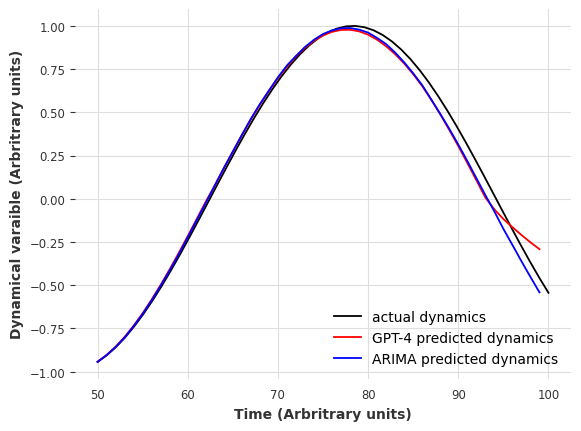

In [137]:


plt.plot(np.linspace(50,100,50),test,'k')
plt.plot(pred_dict['median'],'r')
plt.plot(pred_dict_arima['median'],'b')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics"], loc="lower right")
plt.savefig('oscillator.png')

In [25]:
x2 = np.linspace(0,10,100)
train2 = np.sin(x2[0:50]) + 0.2*np.sin(x2[0:50]*10) + 0.03*np.sin(x2[0:50]*20)
test2 = np.sin(x2[50:100]) + 0.2*np.sin(x2[50:100]*10) + 0.03*np.sin(x2[50:100]*20)

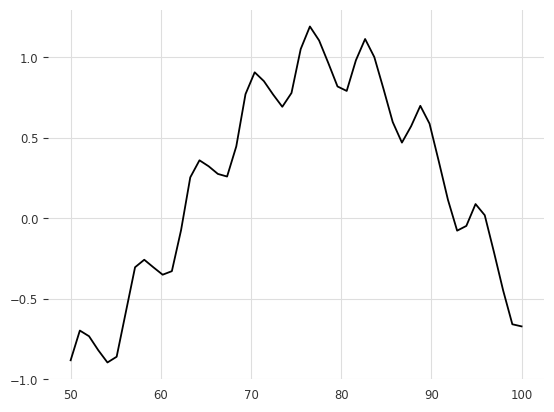

In [26]:
plt.plot(np.linspace(50,100,50),test2,'k')

In [27]:
pred_dict_gpt_sum = get_autotuned_predictions_data(train2, test2, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.28s/it]

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


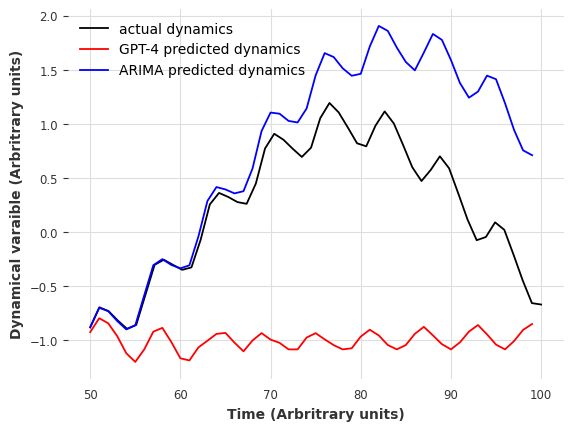

In [30]:
pred_dict_arima_sum = get_autotuned_predictions_data(train2, test2, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)

plt.plot(np.linspace(50,100,50),test,'k')
plt.plot(pred_dict_gpt_sum['median'],'r')
plt.plot(pred_dict_arima_sum['median'],'b')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics"], loc="upper left")
plt.savefig('oscillator2.png')

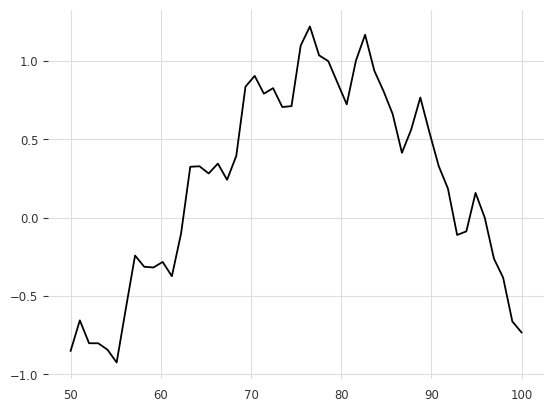

In [31]:
x3 = np.linspace(0,10,100)
train3 = np.sin(x3[0:50]) + 0.2*np.sin(x3[0:50]*10) + 0.1*np.sin(x3[0:50]*20)
test3 = np.sin(x3[50:100]) + 0.2*np.sin(x3[50:100]*10) + 0.1*np.sin(x3[50:100]*20)
plt.plot(np.linspace(50,100,50),test3,'k')



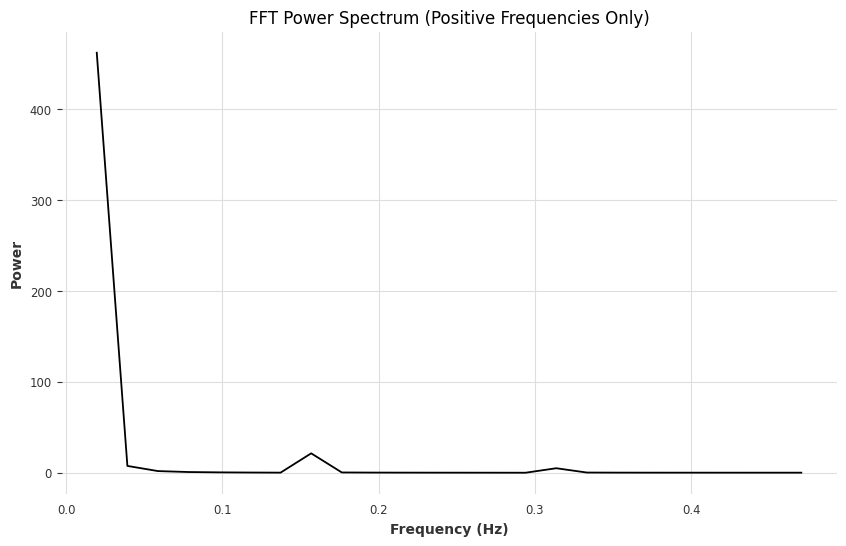

In [35]:
time = np.linspace(50,100,50)


fft_result = np.fft.fft(test3)
fft_freq = np.fft.fftfreq(len(test3), time[1] - time[0])  # Frequency axis

# Calculate the squared amplitude or power
fft_power = np.abs(fft_result) ** 2

# Plot the results for positive frequencies only
positive_freq_mask = fft_freq > 0
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[positive_freq_mask], fft_power[positive_freq_mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum (Positive Frequencies Only)')
plt.grid(True)
plt.show()

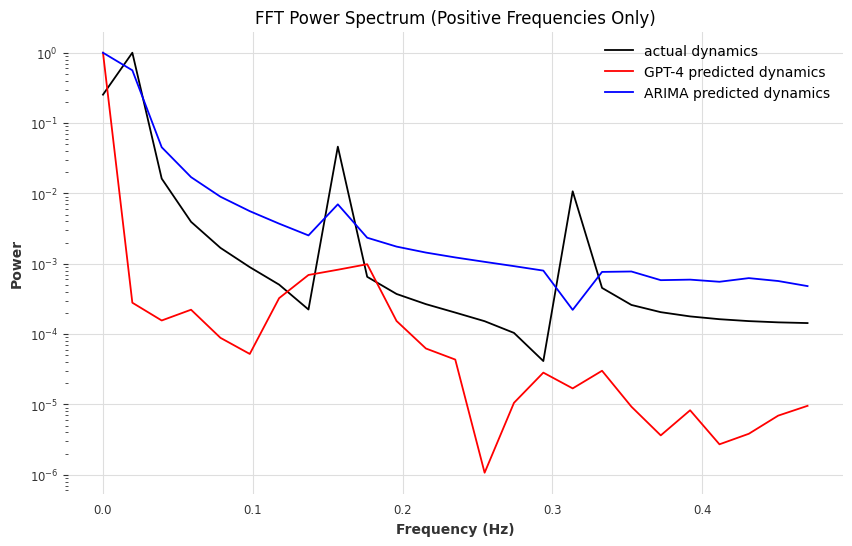

In [46]:
fft_result_gpt = np.fft.fft(pred_dict_gpt_sum['median'])
fft_freq_gpt = np.fft.fftfreq(len(pred_dict_gpt_sum['median']), time[1] - time[0])  # Frequency axis
# Calculate the squared amplitude or power
fft_power_gpt = np.abs(fft_result_gpt) ** 2


fft_result_arima = np.fft.fft(pred_dict_arima_sum['median'])
fft_freq_arima = np.fft.fftfreq(len(pred_dict_arima_sum['median']), time[1] - time[0])  # Frequency axis
# Calculate the squared amplitude or power
fft_power_arima = np.abs(fft_result_arima) ** 2

# Normalize the power spectrum
fft_power = fft_power / np.max(fft_power)
fft_power_arima = fft_power_arima / np.max(fft_power_arima)
fft_power_gpt = fft_power_gpt / np.max(fft_power_gpt)

# Plot the results for positive frequencies only
positive_freq_mask = fft_freq >= 0
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[positive_freq_mask], fft_power[positive_freq_mask],'k')
plt.plot(fft_freq_gpt[positive_freq_mask], fft_power_gpt[positive_freq_mask],'r')
plt.plot(fft_freq_arima[positive_freq_mask], fft_power_arima[positive_freq_mask],'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum (Positive Frequencies Only)')
plt.yscale("log")
plt.grid(True)
plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics"], loc="upper right")
plt.savefig('PSD-oscillator.png')
plt.show()


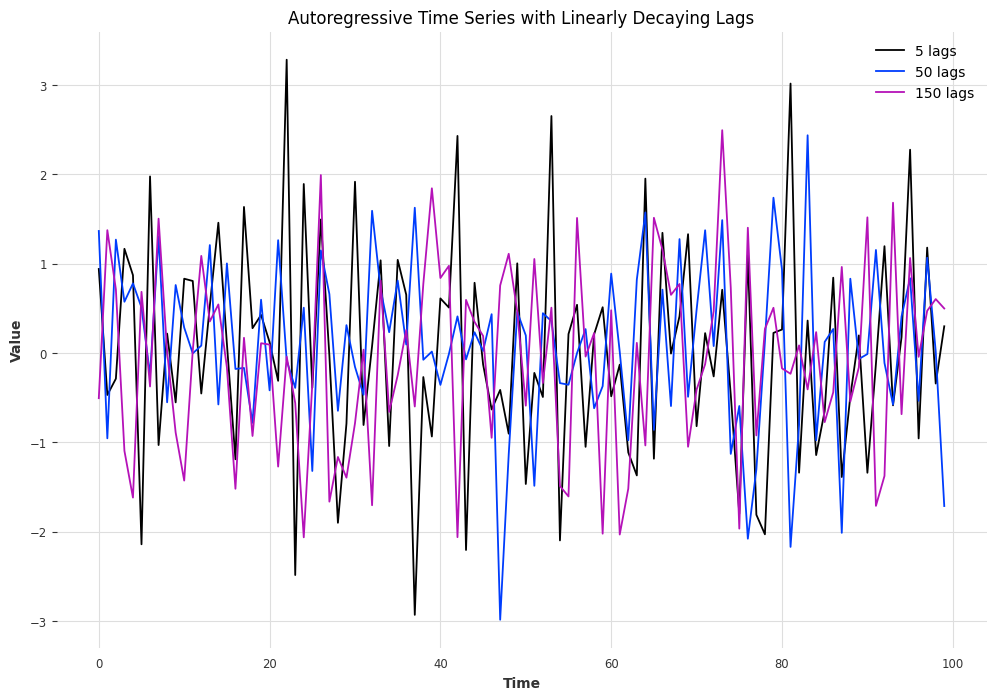

<Figure size 640x480 with 0 Axes>

In [88]:


def generate_autoregressive_series(n_lags, decay_rate, length=100):
    # Generate random noise
    noise = np.random.randn(length)
    
    # Initialize time series with noise
    time_series = noise.copy()
    
    # Generate autoregressive time series with linearly decaying lags
    for i in range(n_lags, length):
        for j in range(1, n_lags+1):
            time_series[i] += decay_rate * (1 - j/n_lags) * time_series[i - j]
    
    return time_series

# Define parameters
length = 100
n_lags_list = [5, 50, 150]
decay_rate = -0.5

# Generate and plot autoregressive time series
plt.figure(figsize=(12, 8))
for n_lags in n_lags_list:
    time_series = generate_autoregressive_series(n_lags, decay_rate, length)
    plt.plot(time_series, label=f'{n_lags} lags')

plt.title('Autoregressive Time Series with Linearly Decaying Lags')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


plt.savefig('autoregressive.png')

In [65]:
pred_dict_gpt_ar = get_autotuned_predictions_data(time_series[0:50], time_series[50:100], hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.35s/it]

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


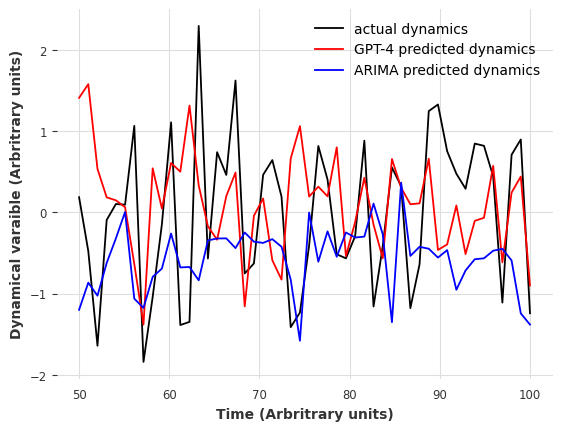

In [85]:
pred_dict_arima_ar = get_autotuned_predictions_data(time_series[0:50], time_series[50:100], hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)

plt.plot(np.linspace(50,100,50),time_series[50:100],'k')                                         
plt.plot(np.linspace(50,100,50),pred_dict_gpt_ar['median'],'r')
plt.plot(np.linspace(50,100,50),pred_dict_arima_ar['median'],'b')


plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics"], loc="upper right")

plt.savefig('autoregressive.png')



In [89]:
def compute_rmse(actual_values, predicted_values):
    """
    Compute Root Mean Square Error (RMSE) between two time series.

    Args:
        actual_values (array-like): Actual values of the time series.
        predicted_values (array-like): Predicted values of the time series.

    Returns:
        float: RMSE value.
    """
    # Ensure both arrays have the same length
    if len(actual_values) != len(predicted_values):
        raise ValueError("Lengths of actual_values and predicted_values must be the same.")

    # Convert input arrays to numpy arrays
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    # Compute the squared error between actual and predicted values
    squared_error = (actual_values - predicted_values) ** 2

    # Compute the mean of squared errors
    mean_squared_error = np.mean(squared_error)

    # Compute the square root of mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error)

    return rmse


In [91]:
rmse_gpt = compute_rmse(time_series[50:100],pred_dict_gpt_ar['median'])
rmse_arima = compute_rmse(time_series[50:100],pred_dict_arima_ar['median'])
print(rmse_gpt,rmse_arima)

1.2499976890076867 1.3168889243556772


In [93]:
rmse_gpt_sin = compute_rmse(test2,pred_dict_gpt_sum['median'])
rmse_arima_sin = compute_rmse(test2,pred_dict_arima_sum['median'])
print(rmse_gpt_sin,rmse_arima_sin)

1.375537107427445 0.7621708999819137


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


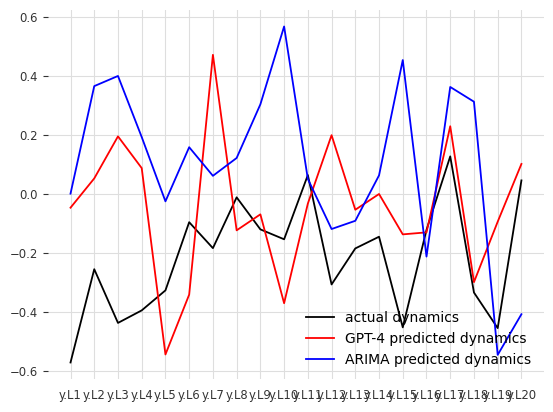

In [94]:
import statsmodels

res = statsmodels.tsa.ar_model.AutoReg(time_series[50:100], lags=20).fit()  # You can adjust the number of lags as needed
res_gpt = statsmodels.tsa.ar_model.AutoReg(pred_dict_gpt_ar['median'], lags=20).fit()  # You can adjust the number of lags as needed
res_arima = statsmodels.tsa.ar_model.AutoReg(pred_dict_arima_ar['median'], lags=20).fit()  # You can adjust the number of lags as needed


#results = model.fit()

#res = AutoReg(data, lags = [1, 11, 12]).fit()


# Get the AR coefficients
ar_coefficients = res.params[1:]  # Exclude the intercept term
ar_coefficients_gpt = res_gpt.params[1:]  # Exclude the intercept term
ar_coefficients_arima = res_arima.params[1:]  # Exclude the intercept term

plt.plot(ar_coefficients,'k-')
plt.plot(ar_coefficients_gpt,'r-')
plt.plot(ar_coefficients_arima,'b-')
plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics"], loc="lower right")

plt.savefig('ar-coeff.png')

In [95]:
variables_dict = globals()

In [104]:
pred_dict_gpt_ar

{'samples':          50        51        52        53        54        55        56  \
 0  0.663043  1.962294  0.431143 -0.062532  0.655955  0.200761 -0.551650   
 1  1.943560  2.046852  0.115191 -0.061013  0.654436 -0.169368 -0.718740   
 2  0.188609  2.425083  0.749626 -0.533928 -1.690393 -0.511143  1.536974   
 3  0.907602  0.746588  0.713170 -0.292407 -0.042279  0.629625  0.158229   
 4  1.376467  0.271648 -1.695963 -1.220010 -0.260508  0.831146 -1.153174   
 5  2.022041  1.342542  0.641271  1.191149  0.340003 -0.072659 -1.114186   
 6  2.280271  1.655456  0.971906  0.675195 -0.058988 -0.180508 -1.736976   
 7  1.447353  1.505582  0.275192  0.432155  1.074692  0.202280 -1.490392   
 8  0.373927  1.385074  1.455961  0.548106 -0.139495  0.857475  0.458991   
 9  1.478746  1.764824  0.126330  1.304061  0.360256 -0.302534  0.707601   
 
          57        58        59  ...        90        91        92        93  \
 0 -1.872167  0.988615 -0.454434  ... -1.935965 -1.935965 -1.935965 -1

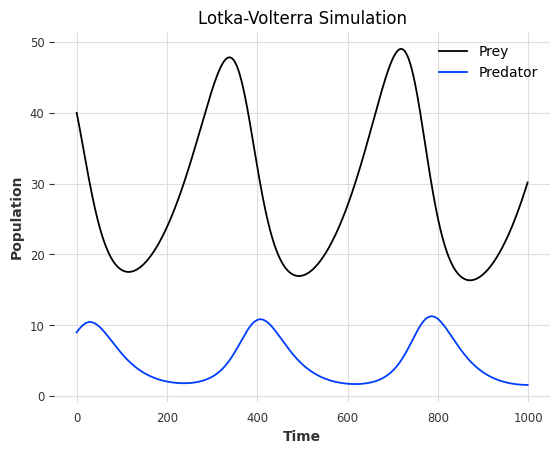

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def lotka_volterra(a, b, c, d, x0, y0, timesteps):
    """
    Simulate the Lotka-Volterra equations.

    Parameters:
    a: float, prey growth rate
    b: float, predation rate
    c: float, predator death rate
    d: float, predator reproduction rate
    x0: float, initial prey population
    y0: float, initial predator population
    timesteps: int, number of time steps

    Returns:
    x_values: numpy array, prey population over time
    y_values: numpy array, predator population over time
    """

    def dx_dt(x, y):
        return a * x - b * x * y

    def dy_dt(x, y):
        return -c * y + d * x * y

    dt = 0.01  # Time step size
    x_values = np.zeros(timesteps)
    y_values = np.zeros(timesteps)

    x_values[0] = x0
    y_values[0] = y0

    for i in range(1, timesteps):
        x = x_values[i - 1]
        y = y_values[i - 1]
        x_values[i] = x + dt * dx_dt(x, y)
        y_values[i] = y + dt * dy_dt(x, y)

    return x_values, y_values

# Example usage:
a = 1
b = 0.2
c = 3
d = 0.1
x0 = 40
y0 = 9
timesteps = 1000

x_values, y_values = lotka_volterra(a, b, c, d, x0, y0, timesteps)

plt.plot(x_values, label='Prey')
plt.plot(y_values, label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Simulation')
plt.show()


In [107]:
window = 10

x_values[0:window]

array([40.        , 39.68      , 39.3554176 , 39.02656442, 38.69375719,
       38.35731683, 38.01756762, 37.67483624, 37.3294509 , 36.98174045])

In [108]:
def concatenate_arrays(x_values, y_values, n):
    """
    Concatenate x_values and y_values into a single array, alternating between n points from each.

    Parameters:
    x_values: numpy array, first set of values
    y_values: numpy array, second set of values
    n: int, number of points to take at a time from each array

    Returns:
    concatenated_array: numpy array, concatenated array
    """

    concatenated_array = np.empty((0,))
    for i in range(0, len(x_values), n):
        concatenated_array = np.concatenate((concatenated_array, x_values[i:i+n], y_values[i:i+n]))

    return concatenated_array

# Example usage:
concatenated_array = concatenate_arrays(x_values, y_values, 10)
print(concatenated_array)


[40.         39.68       39.3554176  ...  1.58353777  1.58317141
  1.58312715]


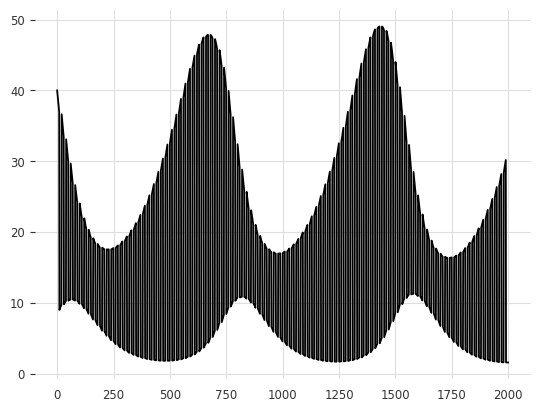

In [116]:
plt.plot(concatenated_array)

In [117]:
train_multi = concatenated_array[0:500]
test_multi = concatenated_array[500:1000]

pred_dict_gpt_multi = get_autotuned_predictions_data(train_multi, test_multi, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)



Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


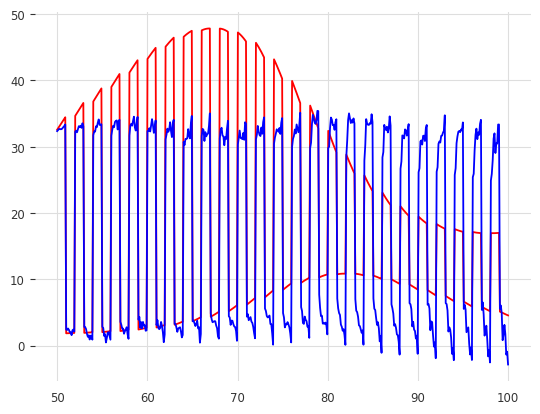

In [121]:
plt.plot(np.linspace(50,100,500),test_multi,'r')
plt.plot(np.linspace(50,100,500),pred_dict_gpt_multi['median'],'b')
plt.show()

In [123]:
train_multi = concatenated_array[0:50]
test_multi = concatenated_array[50:100]

pred_dict_gpt_multi = get_autotuned_predictions_data(train_multi, test_multi, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.16s/it]

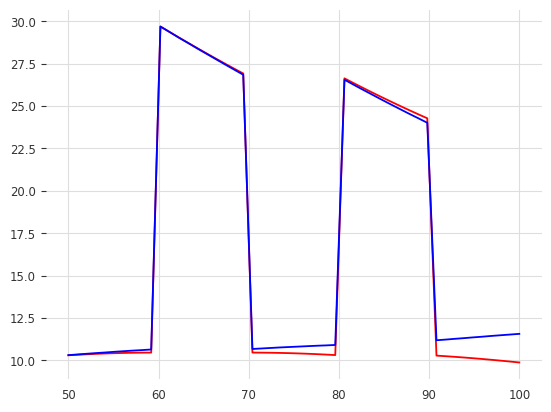

In [124]:
plt.plot(np.linspace(50,100,50),test_multi,'r')
plt.plot(np.linspace(50,100,50),pred_dict_gpt_multi['median'],'b')
plt.show()

In [ ]:
## idea 1: For multivariate
## idea 2: study precision of numbers and forecasting
## idea 3: focus on how this is zero shot training!!
## idea 4: gpt 4 better as it is multimodal compared to gpt-3

In [ ]:
pred_dict_arima_multi = get_autotuned_predictions_data(train_multi, test_multi, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)


In [ ]:
1+1

In [102]:
import pickle

# Assuming you have your variables already defined in memory in Jupyter Notebook

# Specify the filename for the pickle file
pickle_filename = 'all_variables.pickle'

# Get all global variables
variables_dict = globals()

# Filter out objects that cannot be pickled (e.g., modules, functions)
filtered_variables_dict = {key: value for key, value in variables_dict.items() if not callable(value)}

# Open the pickle file in binary write mode
with open(pickle_filename, 'wb') as f:
    # Dump the filtered variables dictionary into the pickle file
    pickle.dump(filtered_variables_dict, f)

print("Filtered variables stored in pickle file:", pickle_filename)


TypeError: cannot pickle 'module' object

In [25]:
import numpy as np

def simulate_multivariate_ar(initial_condition, num_time_series, num_lags, noise_level, dt, num_time_steps):
    """
    Simulate a multivariate AutoRegressive (AR) process.

    Parameters:
        initial_condition (array_like): Initial condition for the time series. Shape: (num_time_series,)
        num_time_series (int): Number of time series to simulate
        num_lags (int): Number of lags for the AR process
        noise_level (float): Standard deviation of Gaussian noise
        dt (float): Time step
        num_time_steps (int): Number of time steps to simulate

    Returns:
        simulated_data (ndarray): Simulated multivariate time series data. Shape: (num_time_steps, num_time_series)
    """
    num_variables = num_time_series * num_lags
    cov_matrix = np.eye(num_variables) * noise_level**2  # Covariance matrix for noise

    ar_matrix = np.random.randn(num_variables, num_variables) * 0.1  # Random AR coefficients
    ar_matrix /= np.max(np.abs(np.linalg.eigvals(ar_matrix)))  # Ensure stability

    simulated_data = np.zeros((num_time_steps, num_time_series))
    prev_values = initial_condition.copy()

    for t in range(num_time_steps):
        noise = np.random.multivariate_normal(np.zeros(num_variables), cov_matrix)
        ar_input = np.concatenate([prev_values[-num_lags*i:] for i in range(1, num_time_series+1)])
        next_values = np.dot(ar_input, ar_matrix) + noise[:num_time_series]
        simulated_data[t] = next_values
        prev_values = np.vstack([prev_values, next_values])

    return simulated_data

# Example usage:
initial_condition = np.array([0.5, -0.3])  # Initial condition for each time series
num_time_series = 2
num_lags = 2
noise_level = 0.1
dt = 0.1
num_time_steps = 100

simulated_data = simulate_multivariate_ar(initial_condition, num_time_series, num_lags, noise_level, dt, num_time_steps)
print(simulated_data)


ValueError: operands could not be broadcast together with shapes (4,) (2,) 

In [26]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess

def simulate_multivariate_ar(n_series, n_lags, n_steps, dt, noise_level, initial_condition):
    """
    Simulate a multivariate AR process.

    Parameters:
        n_series (int): Number of time series.
        n_lags (int): Number of lags for each time series.
        n_steps (int): Number of time steps to simulate.
        dt (float): Time step size.
        noise_level (float): Standard deviation of the noise.
        initial_condition (ndarray): Initial condition for the time series.

    Returns:
        ndarray: Simulated multivariate time series.
    """
    ar_params = np.random.rand(n_series, n_lags)  # Random AR coefficients
    ar_process = ArmaProcess(ar_params, [1], nobs=n_steps)

    noise = noise_level * np.random.randn(n_steps, n_series)  # Gaussian noise

    # Simulate AR process
    ar_data = ar_process.generate_sample() + noise

    # Apply time step size
    ar_data *= dt

    # Apply initial condition
    ar_data[0] = initial_condition

    return ar_data

# Example usage:
n_series = 2
n_lags = 2
n_steps = 100
dt = 0.1
noise_level = 0.1
initial_condition = np.zeros(n_series)

simulated_data = simulate_multivariate_ar(n_series, n_lags, n_steps, dt, noise_level, initial_condition)
print(simulated_data)


ValueError: ar is required to have ndim 1 but has ndim 2

In [28]:
!pip3 install sdeint
import sdeint



Defaulting to user installation because normal site-packages is not writeable
  Using cached sdeint-0.3.0.tar.gz (39 kB)
Using legacy 'setup.py install' for sdeint, since package 'wheel' is not installed.
    Running setup.py install for sdeint ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'sdeint'

In [31]:
!pip install sdeint

  Preparing metadata (setup.py) ... done
  Created wheel for sdeint: filename=sdeint-0.3.0-py3-none-any.whl size=25903 sha256=7295331401b06a416adaa00c078550c825eba87e0018ac0e96c82c7d0541c82a
  Stored in directory: /Users/rdey33/Library/Caches/pip/wheels/1f/a7/39/a63d76610998f2f995bd0459099ca69e5509723fd2e06642da
Successfully built sdeint


In [32]:
import sdeint

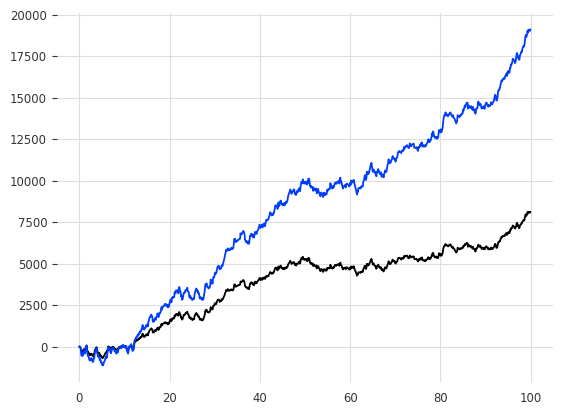

In [34]:
def simulate_ornstein_uhlenbeck(N, mu=None, sigma=None, num_steps=1000, dt=0.01):
    if mu is None:
        mu = np.random.uniform(low=-0.5, high=0.5, size=(N, N))
    if sigma is None:
        sigma = np.random.uniform(low=0.1, high=0.5, size=(N, N))

    def f(X, t):
        return np.matmul(mu, X)

    def g(X, t):
        return sigma

    # Generate initial conditions
    x0 = np.zeros(N)

    # Generate time points
    tspan = np.linspace(0.0, (num_steps - 1) * dt, num_steps)

    # Solve the stochastic differential equation
    X = sdeint.itoint(f, g, x0, tspan)

    return X,tspan

N=2
mu = 0.05*np.array([[0.1, 0.2], [0.3, 0.4]])  # Drift matrix
sigma = 1000*np.array([[0.2, 0.1], [0.3, 0.2]])  # Diffusion matrix
# Simulate the Ornstein-Uhlenbeck process
X,tspan = simulate_ornstein_uhlenbeck(N, mu, sigma,num_steps=1000,dt=dt)




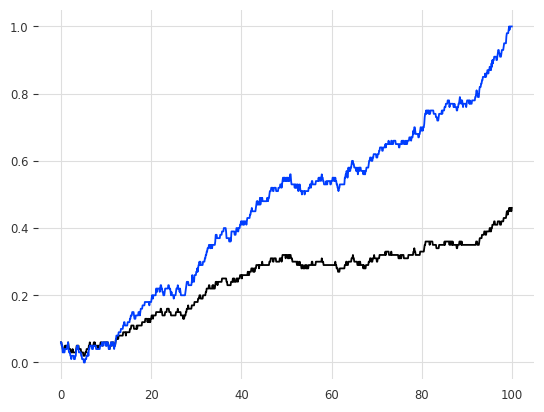

In [47]:
# Scale the array using Min-Max scaling
X_r = (X - X.min()) / (X.max() - X.min())

X_r = np.round(X_r, decimals=2)

plt.plot(tspan,X_r)
plt.show()

In [48]:
X_r

array([[0.06, 0.06],
       [0.06, 0.06],
       [0.05, 0.05],
       ...,
       [0.46, 1.  ],
       [0.45, 1.  ],
       [0.46, 1.  ]])

In [49]:
train2 = X_r[0:50,0]
test2 = X_r[50:100,0]

In [50]:
train2

array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05,
       0.05, 0.04, 0.05, 0.05, 0.05, 0.06, 0.05, 0.04, 0.04, 0.04, 0.04,
       0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.04, 0.05, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.03])

In [51]:
pred_dict2 = get_autotuned_predictions_data(train2, test2, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf



100%|████████████████████████████████████| 1/1 [00:11<00:00, 11.18s/it]

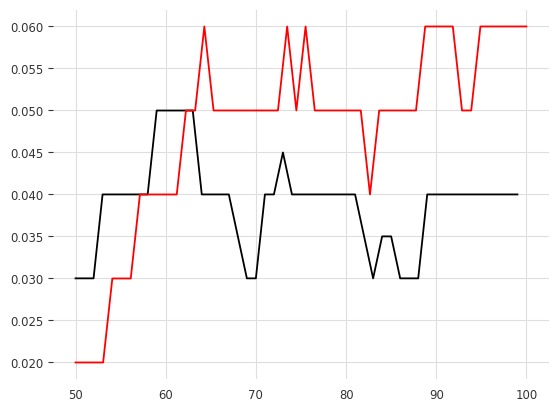

In [52]:
plt.plot(pred_dict2['median'])
plt.plot(np.linspace(50,100,50),test2,'r')

In [53]:
train3 = X_r[0:300,0]
test3 = X_r[300:500,0]

In [54]:
pred_dict3 = get_autotuned_predictions_data(train3, test3, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf



100%|████████████████████████████████████| 1/1 [00:42<00:00, 42.77s/it]

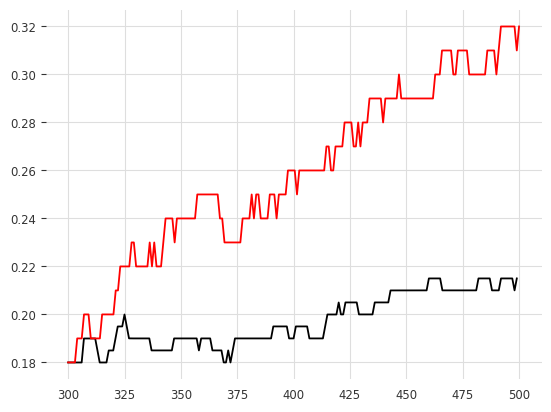

In [65]:
plt.plot(pred_dict3['median'])
plt.plot(np.linspace(300,500,200),test3,'r')

In [63]:
np.linspace(300,500,201)

array([300., 301., 302., 303., 304., 305., 306., 307., 308., 309., 310.,
       311., 312., 313., 314., 315., 316., 317., 318., 319., 320., 321.,
       322., 323., 324., 325., 326., 327., 328., 329., 330., 331., 332.,
       333., 334., 335., 336., 337., 338., 339., 340., 341., 342., 343.,
       344., 345., 346., 347., 348., 349., 350., 351., 352., 353., 354.,
       355., 356., 357., 358., 359., 360., 361., 362., 363., 364., 365.,
       366., 367., 368., 369., 370., 371., 372., 373., 374., 375., 376.,
       377., 378., 379., 380., 381., 382., 383., 384., 385., 386., 387.,
       388., 389., 390., 391., 392., 393., 394., 395., 396., 397., 398.,
       399., 400., 401., 402., 403., 404., 405., 406., 407., 408., 409.,
       410., 411., 412., 413., 414., 415., 416., 417., 418., 419., 420.,
       421., 422., 423., 424., 425., 426., 427., 428., 429., 430., 431.,
       432., 433., 434., 435., 436., 437., 438., 439., 440., 441., 442.,
       443., 444., 445., 446., 447., 448., 449., 45

In [ ]:
pwd

